In [1]:
import cv2
import numpy
import platform
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import imutils
from tqdm import tqdm

print("Python version: {}\nOpenCV version: {}".format(platform.python_version(), cv2.__version__))

imageName = '../data/line_detection_data/0205584046905.nutrition.jpg'

Python version: 3.6.11
OpenCV version: 3.3.1


In [2]:
#def get_coef(img):
#    return np.count_nonzero(img,keepdims=True).sum()/(256**3)

In [3]:
def get_coef(myimage):
    shape = myimage.shape
    return myimage.sum()/(shape[0]*shape[1])
def process_number(x):
    n=round(x)
    if n%2==1:
        return n
    else:
        return n+1

In [4]:
class TableMask:
    
    def __init__(self,image,predicted_mask):
        self.image = image
        self.predicted_mask = predicted_mask
        self.original_image_shape = (image.shape[1],image.shape[0])
        self.corrected_mask = None
        self.resized_bounding_box = None
        self.original_bounding_box = None
        self.image_with_bounding_box = None
        self.cropped_table = None
    
    @staticmethod
    def get_coef(myimage):
        shape = myimage.shape
        return myimage.sum()/(shape[0]*shape[1])
    @staticmethod
    def process_number(x):
        n=round(x)
        if n%2==1:
            return n
        else:
            return n+1
    def get_predicted_area_ratio(self):
        shape = self.corrected_mask.shape
        return (self.corrected_mask==255).sum()/(shape[0]*shape[1]*3)
    
    def get_bounding_box_coordinates(self):
        img_bw = cv2.cvtColor(self.predicted_mask,cv2.COLOR_RGB2GRAY)
        se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (30,30))
        mask1 = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, se1)
        se2 = np.ones((30,30),np.uint8)
        mask2  = cv2.dilate(mask1, se2)
        mask = (1*(mask2==255)).astype('uint8')
        out = np.logical_and(img_bw,mask).astype('uint8')
        se3 = cv2.getStructuringElement(cv2.MORPH_RECT, (30,30))
        cleaned_out = cv2.morphologyEx(out, cv2.MORPH_OPEN, se1)
        cnts = cv2.findContours(cleaned_out.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        try:
            c = max(cnts, key=cv2.contourArea)
            rect = cv2.boundingRect(c)
            x,y,w,h = rect
            self.resized_bounding_box = rect
        except:
            self.resized_bounding_box = (0,0,0,0)

    def generate_corrected_mask(self):
        x,y,w,h = self.resized_bounding_box
        corrected_mask = np.zeros((256,256,3), np.uint8)
        self.corrected_mask = cv2.resize(cv2.rectangle(corrected_mask,(x,y),(x+w,y+h),(255,255,255),-1),self.original_image_shape)
    
    def get_bounding_box_coordinates_on_original_image(self):
        point1_org = (np.where(self.corrected_mask==255)[1][0] , np.where(self.corrected_mask==255)[0][0])
        point2_org = (np.where(self.corrected_mask==255)[1][-1] , np.where(self.corrected_mask==255)[0][-1])
        self.original_bounding_box = (point1_org[0],point1_org[1],point2_org[0]-point1_org[0],point2_org[1]-point1_org[1])
    
    def draw_bounding_box(self):
        x,y,w,h = self.original_bounding_box
        self.image_with_bounding_box = cv2.rectangle(self.image,(x,y),(x+w,y+h),(0,255,0),10)
        
        
    def get_cropped_image(self):
        x,y,w,h = self.original_bounding_box
        return self.image[y:y+h,x:x+w]

Wall time: 751 ms


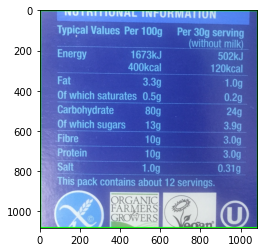

In [5]:
%%time
table_mask_dir = '../results/test_table_mask/'
image_dir= '../results/test_image/'
image_name = '0058449771890.nutrition.jpg'
image = cv2.imread(os.path.join(image_dir,image_name))
predicted_mask = cv2.imread(os.path.join(table_mask_dir,image_name))

tm = TableMask(image.copy(),predicted_mask.copy())
tm.get_bounding_box_coordinates()
tm.generate_corrected_mask()
tm.get_bounding_box_coordinates_on_original_image()
tm.draw_bounding_box()
plt.imshow(tm.get_cropped_image())

In [127]:
tm.predicted_mask.shape

(256, 256, 3)

In [128]:
tm.get_predicted_area_ratio()

0.6089774951076321

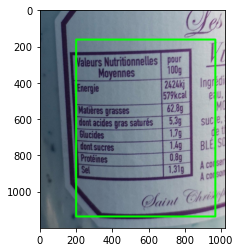

In [120]:
plt.imshow(tm.image_with_bounding_box)

In [59]:
table_mask_dir = '../results/test_table_mask/'
image_dir= '../results/test_image/'
image_name = '3560070098569.nutrition.jpg'
image = cv2.imread(os.path.join(image_dir,image_name))
predicted_mask = cv2.resize(cv2.imread(os.path.join(table_mask_dir,image_name)),(256,256))
tm = TableMask(image.copy(),predicted_mask.copy())
img_bw = cv2.cvtColor(tm.predicted_mask,cv2.COLOR_RGB2GRAY)
se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (30,30))
mask1 = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
se2 = np.ones((10,10),np.uint8)
mask2  = cv2.dilate(mask1, se2)
mask = (1*(mask2==255)).astype('uint8')
out = np.logical_and(img_bw,mask).astype('uint8')
se3 = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
cleaned_out = cv2.morphologyEx(out, cv2.MORPH_OPEN, se1)
#(_, cnts, _) = cv2.findContours(cleaned_out.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
border = cv2.copyMakeBorder(cleaned_out, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0 )
_, cnts, hierarchy = cv2.findContours(border, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE, offset=(-1, -1))
#cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
rect = cv2.boundingRect(c)
x,y,w,h = rect
print(rect)
img = cv2.rectangle(cv2.resize(image,(256,256)).copy(),(x,y),(x+w,y+h),(0,255,0),2)

(9, 94, 217, 132)


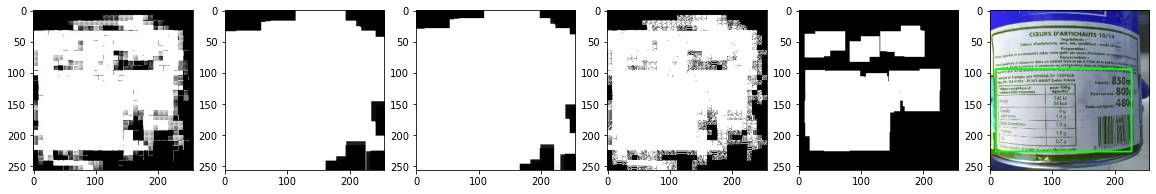

In [60]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,6,1)
ax1.imshow(img_bw,cmap='gray')
ax2 = fig.add_subplot(1,6,2)
ax2.imshow(mask1,cmap='gray')
ax3 = fig.add_subplot(1,6,3)
ax3.imshow(mask2,cmap='gray')
ax4 = fig.add_subplot(1,6,4)
ax4.imshow(out,cmap='gray')
ax5 = fig.add_subplot(1,6,5)
ax5.imshow(cleaned_out,cmap='gray')
ax6 = fig.add_subplot(1,6,6)
ax6.imshow(img,cmap='gray')

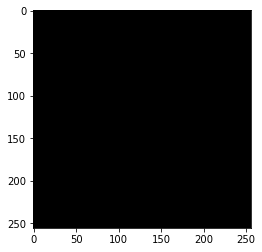

In [11]:
plt.imshow(mask,cmap='gray')

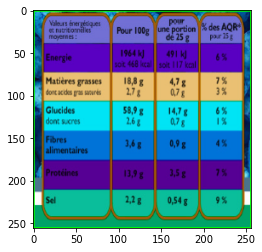

In [254]:
plt.imshow(img,cmap='gray')

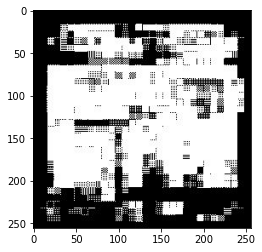

In [100]:
plt.imshow(tm.predicted_mask,cmap='gray')

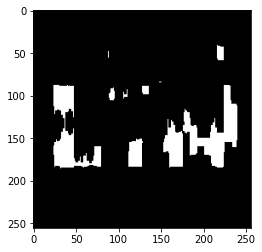

In [101]:
plt.imshow(np.logical_and(img_bw,mask),cmap='gray')

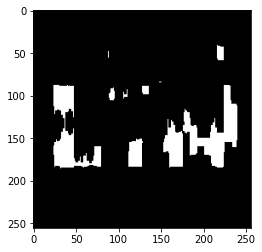

In [102]:
plt.imshow(cleaned_out,cmap='gray')

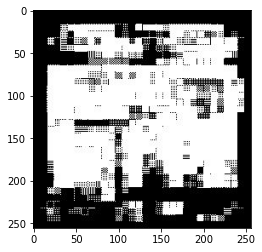

In [103]:
plt.imshow(tm.predicted_mask,cmap='gray')

In [153]:
x,y,w,h = tm.original_bounding_box

In [154]:
tm.original_bounding_box

(115, 47, 2980, 967)

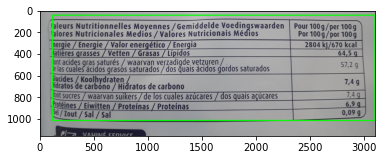

In [155]:
plt.imshow(tm.image_with_bounding_box)

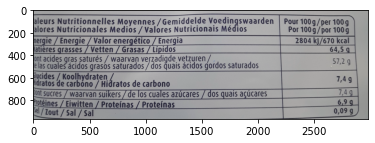

In [156]:
plt.imshow(tm.image[y:y+h,x:x+w])

In [85]:
tm.rect

(0, 97, 247, 79)

In [7]:
import datetime
now = datetime.datetime.now()
corrected_mask_dir = os.path.join('../results','test_corrected_mask_'+now.strftime('%Y-%m-%d-%H-%M'))
if os.path.exists(corrected_mask_dir)==False:
    os.mkdir(corrected_mask_dir)
tb_mask = TableMask('../results/test_image/', '../results/test_table_mask/', corrected_mask_dir=corrected_mask_dir)
tb_mask.generate_masks()

TypeError: __init__() got an unexpected keyword argument 'corrected_mask_dir'

In [6]:
def iou(gt_mask,pred_mask):
    intersection = np.logical_and(gt_mask,pred_mask).sum()
    union = np.logical_or(gt_mask,pred_mask).sum()
    return intersection/union

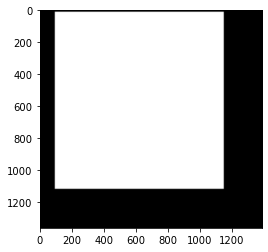

In [13]:
plt.imshow(tb_mask.corrected_mask)

In [8]:
scores=[]
table_mask_dir = '../results/test_table_mask'
image_dir = '../results/test_image/'
images = [x.split('/')[-1].split('.')[0] for x in os.listdir(image_dir)]

for table_id in tqdm(images):
    pred_mask = cv2.imread(os.path.join(table_mask_dir,table_id+'.nutrition.jpg'))
    image = cv2.imread(os.path.join(image_dir,table_id+'.nutrition.jpg'))
    tb_mask = TableMask(image, pred_mask)
    tb_mask.get_bounding_box_coordinates()
    tb_mask.generate_corrected_mask()
    gt_mask = cv2.imread(os.path.join('../data/test/table_mask/',table_id+'.nutrition.jpeg'))
    scores.append(iou(gt_mask,tb_mask.corrected_mask))
    
print('score: {}'.format(sum(scores)/len(images)))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:05<00:00,  8.26it/s]

score: 0.6572367901724154


In [402]:
corrected_mask_dir

'../results\\test_corrected_mask_2020-09-18-15-38'

In [388]:
table_id = '20293819'

In [389]:
pred_mask = cv2.imread(os.path.join(corrected_mask_dir,table_id+'.nutrition.jpg'))
gt_mask = cv2.imread(os.path.join('../data/table_mask/',table_id+'.nutrition.jpeg'))

In [390]:
iou(gt_mask,pred_mask)

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [327]:
cv2.bitwise_and(gt_mask,pred_mask).sum()/cv2.bitwise_or(gt_mask,pred_mask).sum()

4.322979132127158

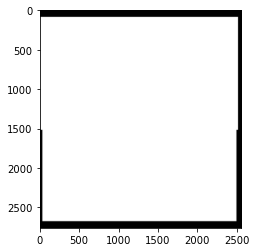

In [334]:
plt.imshow(cv2.bitwise_or(gt_mask,pred_mask))

In [321]:
cv2.bitwise_and(gt_mask,pred_mask).sum()

2666991096

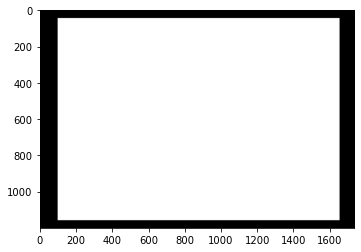

In [358]:
plt.imshow(gt_mask)

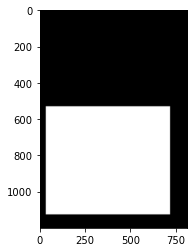

In [357]:
plt.imshow(pred_mask)

In [359]:
table_id

'3046920016377'

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.45it/s]

score: 0.6181308267151929


In [316]:
images[65]

'20293819'

In [315]:
[i for i,x in enumerate(scores) if x>1]

[65, 103, 116, 181]

In [403]:
import datetime
now = datetime.datetime.now()
for imageName in   tqdm([os.path.join('../results/test_table_mask/',x) for x in os.listdir('../results/test_table_mask/') if x.split('.')[-1]=='jpg']): 
    result_dir_image_bbx = os.path.join('../results','test_image_with_bbx_'+now.strftime('%Y-%m-%d-%H-%M'))
    if os.path.exists(result_dir_image_bbx)==False:
        os.mkdir(result_dir_image_bbx)
    result_dir_corrected_mask = os.path.join('../results','test_corrected_mask_'+now.strftime('%Y-%m-%d-%H-%M'))
    if os.path.exists(result_dir_corrected_mask)==False:
        os.mkdir(result_dir_corrected_mask)
    image_org = plt.imread(os.path.join('../results/test_image/',imageName.split('/')[-1]))
    image = cv2.resize(image_org.copy(),(256,256))
    shape = image_org.shape
    img = plt.imread(imageName)
    blur = cv2.GaussianBlur(img,(5,5),0)
    img_bw = 255*(cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY) < 170).astype('uint8')
    binarized = 1*(img_bw<100)
    coef = get_coef(binarized)
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (process_number(coef*60),process_number(coef*60)))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (process_number(coef*20),process_number(coef*20)))
    mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    mask = np.dstack([mask, mask, mask]) // 255
    out = img * mask
    clened_out = (255*(cv2.cvtColor(out.astype('uint8'), cv2.COLOR_RGB2GRAY) ==0)).astype('uint8')
    cnts = cv2.findContours(cleaned_out.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    try:
        c = max(cnts, key=cv2.contourArea)
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        # Create a black image
        corrected_mask = np.zeros((256,256,3), np.uint8)
        cv2.rectangle(corrected_mask,(x,y),(x+w,y+h),(255,255,255),-1)
        corrected_mask = cv2.resize(corrected_mask,(shape[1],shape[0]))
        point1_org = (np.where(corrected_mask==255)[1][0] , np.where(corrected_mask==255)[0][0])
        point2_org = (np.where(corrected_mask==255)[1][-1] , np.where(corrected_mask==255)[0][-1])
        image_org = cv2.rectangle(image_org,point1_org,point2_org,(0,255,0),10)
         #draw the contours of c
        #cv2.drawContours(image, [c], -1, (0, 0, 0), 1)
    except:
        pass
    plt.imsave(os.path.join(result_dir_corrected_mask,imageName.split('/')[-1]),corrected_mask)
    plt.imsave(os.path.join(result_dir_image_bbx,imageName.split('/')[-1]),image_org)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:22<00:00,  2.19it/s]


In [130]:
import datetime
now = datetime.datetime.now()
for imageName in   tqdm([os.path.join('../results/table_mask/',x) for x in os.listdir('../results/table_mask/') if x.split('.')[-1]=='jpg']): 
    result_dir_image_bbx = os.path.join('../results','image_with_bbx_'+now.strftime('%Y-%m-%d-%H-%M'))
    if os.path.exists(result_dir_image_bbx)==False:
        os.mkdir(result_dir_image_bbx)
    result_dir_corrected_mask = os.path.join('../results','corrected_mask_'+now.strftime('%Y-%m-%d-%H-%M'))
    if os.path.exists(result_dir_corrected_mask)==False:
        os.mkdir(result_dir_corrected_mask)
    image = plt.imread(os.path.join('../results/image/',imageName.split('/')[-1]))
    shape = image.shape
    img = plt.imread(imageName)
    blur = cv2.GaussianBlur(img,(process_number(shape[0]*0.03),process_number(shape[0]*0.03)),0)
    img_bw = 255*(cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY) < 170).astype('uint8')
    binarized = 1*(img_bw<100)
    coef = get_coef(binarized)
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (process_number(coef*shape[0]*0.5),process_number(coef*shape[1]*0.5)))
    #se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
    mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    mask = np.dstack([mask, mask, mask]) // 255
    out = img * mask
    cleaned_out = (255*(cv2.cvtColor(out.astype('uint8'), cv2.COLOR_RGB2GRAY) ==0)).astype('uint8')
    cnts = cv2.findContours(cleaned_out.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    try:
        c = max(cnts, key=cv2.contourArea)
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        # Create a black image
        corrected_mask = np.zeros((shape[0],shape[1],3), np.uint8)
        cv2.rectangle(corrected_mask,(x,y),(x+w,y+h),(255,255,255),-1)
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),10)
             #draw the contours of c
            #cv2.drawContours(image, [c], -1, (0, 0, 0), 1)
    except:
        pass
    plt.imsave(os.path.join(result_dir_corrected_mask,imageName.split('/')[-1]),corrected_mask)
    plt.imsave(os.path.join(result_dir_image_bbx,imageName.split('/')[-1]),image)

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [06:29<00:00,  1.54s/it]


In [ ]:
for imageName in   tqdm([os.path.join('../results/table_mask/',x) for x in os.listdir('../results/table_mask/') if x.split('.')[-1]=='jpg']): 
    image_original = cv2.resize(plt.imread(os.path.join('../results/image/',imageName.split('/')[-1])),(256,256))
    image = cv2.resize(plt.imread(os.path.join('../results/image/',imageName.split('/')[-1])),(256,256))
    img = plt.imread(imageName)
    img_bw = 255*(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) < 170).astype('uint8')
    
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (30,30))
    #se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

    mask = np.dstack([mask, mask, mask]) / 255
    out = img * mask

    cleaned_out = (255*(cv2.cvtColor(out.astype('uint8'), cv2.COLOR_RGB2GRAY) <10)).astype('uint8')

    cnts = cv2.findContours(cleaned_out.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    try:
        c = max(cnts, key=cv2.contourArea)
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        # Create a black image
        corrected_mask = np.zeros((256,256,3), np.uint8)
        cv2.rectangle(corrected_mask,(x,y),(x+w,y+h),(255,255,255),-1)
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
         #draw the contours of c
        #cv2.drawContours(image, [c], -1, (0, 0, 0), 1)
    except:
        pass

        plt.imsave(os.path.join('../results/table_mask_corrected',imageName.split('/')[-1]),corrected_mask)
        plt.imsave(os.path.join('../results/image_with_bbx',imageName.split('/')[-1]),image)

In [425]:
for imageName in   tqdm([os.path.join('../results/table_mask/',x) for x in os.listdir('../results/table_mask/') if x.split('.')[-1]=='jpg']): 
    
    image = cv2.resize(plt.imread(os.path.join('../results/image/',imageName.split('/')[-1])),(256,256))
    img = plt.imread(imageName)
    img_bw = 255*(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) < 170).astype('uint8')
    
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (30,30))
    #se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

    mask = np.dstack([mask, mask, mask]) / 255
    out = img * mask

    cleaned_out = (255*(cv2.cvtColor(out.astype('uint8'), cv2.COLOR_RGB2GRAY) <10)).astype('uint8')

    cnts = cv2.findContours(cleaned_out.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    try:
        c = max(cnts, key=cv2.contourArea)
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        # Create a black image
        corrected_mask = np.zeros((256,256,3), np.uint8)
        cv2.rectangle(corrected_mask,(x,y),(x+w,y+h),(255,255,255),-1)
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
         #draw the contours of c
        #cv2.drawContours(image, [c], -1, (0, 0, 0), 1)
    except:
        pass

        plt.imsave(os.path.join('../results/table_mask_corrected',imageName.split('/')[-1]),corrected_mask)
        plt.imsave(os.path.join('../results/image_with_bbx',imageName.split('/')[-1]),image)

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:25<00:00,  9.79it/s]


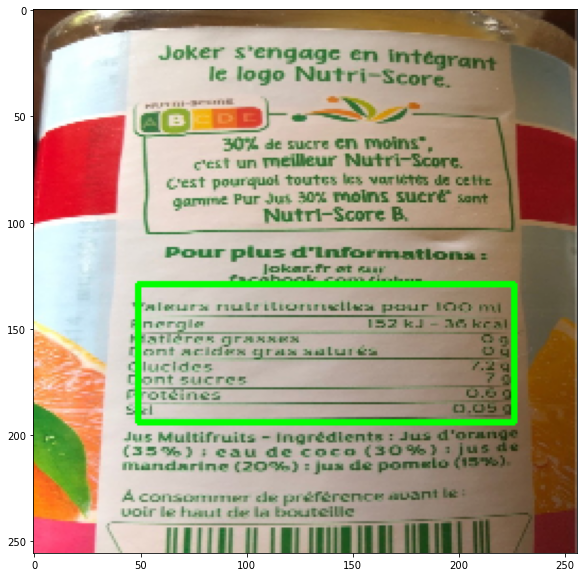

In [168]:
# show the output image
plt.figure(figsize=(20,10))
plt.imshow(image)

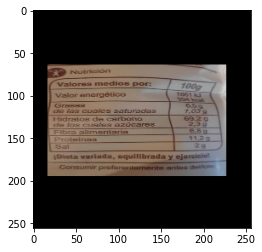

In [157]:
imageName.split('/')[-1]

In [29]:
denoised.shape

(256, 256)

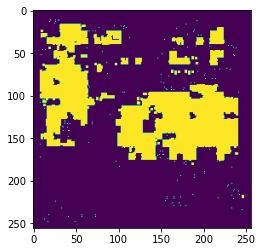

In [31]:
plt.imshow(cleaned_out)

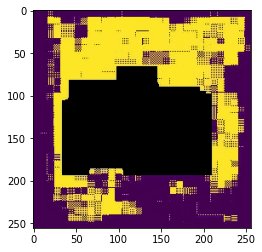

In [218]:
plt.imshow(255*(cv2.cvtColor(out.astype('uint8'), cv2.COLOR_BGR2GRAY) >10).astype('uint8'))

In [121]:
img[128]

IndexError: index 129 is out of bounds for axis 2 with size 3

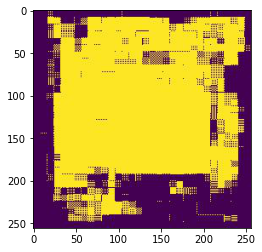

In [143]:
plt.imshow(img)